## Goal
The goal of this competition is to use various factors to predict obesity risk in individuals, which is related to cardiovascular disease.

이 대회의 목표는 다양한 요인을 사용하여 심혈관 질환과 관련있는 개인의 비만 위험을 예측하는 것입니다 -> 분류문제


## About the Dataset
Several datasets are loaded into the notebook from Kaggle's input directory.

The data consist of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition , data was generated from a deep learning model trained on the [Obesity risk dataset](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster).

이 데이터는 14세부터 61세까지 다양한 식습관과 체력 상태를 가진 멕시코, 페루 및 콜롬비아의 사람들의 비만 수준을 측정한 것으로 구성되어 있습니다.
이 데이터는 [Obesity risk dataset]에서 훈련된 딥러닝 모델을 기반으로 생성되었습니다.


## Package and Libraries
- NumPy: Used for numerical computations.
- Pandas: Utilized for data processing, including CSV file I/O.
- Matplotlib and Seaborn: Employed for data visualization.
- Scikit-learn (sklearn): Utilized for machine learning tasks.
- LightGBM: A gradient boosting framework used for classification.
- CatBoost: A gradient boosting library used for classification.
- RandomForestClassifier, ExtraTreesClassifier: Ensemble methods used for classification.


## Preprocessing
Data preprocessing steps are performed, including handling missing values, encoding categorical variables, and scaling numerical features.


## Machine Learning Models
Various classification models are implemented and trained on the preprocessed data:
- Random Forest
- LGBM (Light Gradient Boosting Machine)
- CatBoost
- XGBoost
Model performance metrics such as accuracy, recall, precision, and confusion matrix are evaluated.


## SHAP (SHapley Additive exPlanations)
SHAP values are calculated to explain the output of the trained CatBoost model.


## Prediction and Submission
The best performing model (LGBM) is used to predict the obesity level for test data.

# 1-1. Import Library

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import optuna
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.base import clone

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import CatBoostEncoder, MEstimateEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from collections import Counter




#choose color palette
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

# 1-2. Load Data

In [1]:
train = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e2/sample_submission.csv")

In [2]:
# check shape of data
print(f'The Train dataset has {train.shape[0]}rows and {train.shape[1]}columns.')
print(f'The Test dataset has {test.shape[0]}rows and {test.shape[1]}columns.')

The Train dataset has 20758rows and 18columns.
The Test dataset has 13840rows and 17columns.


In [3]:
train

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [5]:
train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
test

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation
13836,34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
13837,34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation
13838,34596,Male,21.000000,1.620000,53.000000,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation


## About Data
- The train dataset have 20758 rows and 18 columns.
- There are no missing or duplicate values in any of the columns.
- Target Variable : Obesity Classification

# 1-3. Imformation about Features in the data
## family_history_with_overweight : 
Based on the data provided, the family_history_with_overweight column is a binary variable that indicates the presence or absence of a family history of obesity in the respondent.

제공된 데이터에 따르면, family_history_with_overweight는 응답자의 비만 가족력의 존재 또는 부재를 나타내는 이진 변수입니다.

Based on the data provided
> 17,014 people checked “yes,” meaning they have a family history of obesity.
3,744 people checked “no,” which means they have no family history of obesity.

## FAVC :
Based on the data you provided, it can be assumed that the FAVC column is a binary variable that indicates whether a person frequently consumes high-calorie foods (yes) or not (no).

제공된 데이터에 따르면 FAVC는 개인이 고칼로리 음식을 자주 섭취하는지 여부를 나타내는 이진 변수입니다.

Based on the data provided:
> 18,982 people checked “yes,” which means they often consume high-calorie foods.
1,776 people marked “no,” which means they do not frequently consume high-calorie foods.

## FCVC:
Based on the data provided, FCVC appears to be a scale related to the level or frequency of consumption of Vegetables by individuals. The range of values from 1 to 3 may indicate different levels of consumption frequency.

제공된 데이터에 따르면 FCVC는 개인이 채소를 섭취하는 수준 또는 빈도와 관련된 척도입니다. 1에서 3까지의 범위는 섭취 빈도를 나타낼 수 있습니다.

## NCP : 
Based on the data provided, NCP appears to be a scale related to the number of main meals the person is consuming in a day.

제공된 데이터를 기반으로 하면 NCP는 하루에 섭취하는 주요 식사의 횟수와 관련된 척도인 것으로 보입니다.

## CAEC :
Based on the data provided, the CAEC column is likely a categorical variable that describes the frequency of consuming food or supplements between meals.

제공된 데이터에 따르면, CAEC는 식사 사이에 음식을 섭취하는 빈도는 나타내는 범주형 변수인 것으로 보입니다.

Based on the data provided:
>17,529 people selected "Sometimes," which means they sometimes consume certain types of foods or supplements
2,472 people selected "Frequently", indicating frequent use.
478 people chose "Always", which means they always use.
279 people marked “no,” which may indicate lack of use or refusal to answer this question.

## CH2O:
It can be assumed that CH2O is a measure or scale likely related to water consumption. Values from 1 to 3 may represent different levels or frequencies of water consumption.

CH2O는 물 섭취와 관련된 척도일 수 있습니다.
1부터 3까지의 값은 물 소비 수준이나 빈도를 나타낼 수 있습니다.

## SCC: 
Based on the data provided, the SCC column is a binary variable that indicates whether the person is monitoring the calorie consumption.

제공된 데이터에 따르면, SCC는 응답자가 칼로리 소비를 모니터링하는 지를 나타낸 이진 변수입니다.

Based on the data provided:
>20,071 people checked "no", which means they do not drink alcohol.
245 people checked "yes", which means they smoke.

## FAF:
It can be assumed that the FAF is a measure or scale related to physical activity. The values are likely to reflect the number of hours spent in physical activity per day or during a given period of time.

FAF는 신체 활동에 관한 측정 항목 혹은 척도일 것입니다.
값은 아마도 하루나 주어진 기간 동안 신체 활동에 소요된 시간으로 추정됩니다.

## TUE:
It can be assumed that TUE may be an indicator or scale related to time spent in front of television (Television Viewing Time). The values may indicate the number of hours spent watching television per day or during a specific period of time.

TUE는 텔레비전 시청 시각과 관련된 지표 또는 척도일 것으로 추정됩니다.
값은 하루 혹은 특정 기간 동안 텔레비전을 시청하는 시간을 나타낼 수 있습니다.

## CALC:
Based on the data provided, CALC column is likely a categorical variable that describethe frequency of consumption of alcohol.

제공된 데이터에 따르면, CALC는 알코올 섭취 빈도를 나타낸 범주형 변수입니다.

Based on the data provided:
>15,066 people selected "Sometimes", which means they sometimes consume alcohol.
5,163 people selected “no,” which may indicate not consuming calcium or taking calcium supplements.
529 people selected "Frequently", indicating that they frequently consume calcium or take calcium supplements.

## MTRANS :
Based on the data provided, the MTRANS column is a variable describing the preferred mode of transport used by respondents.

제공된 데이터에 따르면 MTRANS은 응답자가 선호하는 교통수단을 설명하는 변수입니다.

Based on the data provided:
>16,687 people chose "Public Transportation", which means they prefer to use public transport.
3,534 people chose "Automobile", indicating a preference for a car.
467 people chose "Walking", which means they prefer to walk.
38 people chose "Motorbike", indicating a preference for a motorcycle.
32 people chose "Bike", which means they prefer to ride a bicycle.

## NObeyesdad :
Based on the data provided, the NObeyesdad column is a variable describing the type of obesity or weight category of the respondents. 

제공된 데이터를 기반으로 하면, NObeyedad는 응답자의 비만 유형 또는 체중 범주를 설명하는 변수입니다.

Based on the data provided:
>4046 people are classified as "Obesity_Type_III".
3248 people are classified as "Obesity_Type_II".
3082 people are classified as "Normal_Weight".
2910 people are classified as "Obesity_Type_I".
2523 people are classified as "Insufficient_Weight".
2522 people are classified as "Overweight_Level_II".
2427 people are classified as "Overweight_Level_I".

# 2. EDA
## Let's visualize each of the variables:

In [7]:
print(train.isnull().sum())
print(test.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC           

- There is no Missing Value

In [8]:
def showchart(df, column_name):
    
    # Converting string values to categorical
    # 문자열 값을 범주형으로 변환
    df[column_name] = df[column_name].astype('category')
    
    # Calculating the frequency of values in the column
    # 열의 값의 빈도를 계산
    counts = df[column_name].value_counts()
    
    # Sorting the values in the column by their frequency in descending order
    # 열의 값의 빈도 순서대로 정렬
    counts_sorted = counts.sort_values(ascending=False)
    
    # subplot을 생성
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    plt.subplots_adjust(wspace = 0.5)
    
    # 파이 차트
    axes[0].pie(counts.values, labels=counts_sorted.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    
    # 막대 그래프
    sns.countplot(data=df, y=column_name, ax=axes[1], order=counts_sorted.index, palette="pastel")
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')
    
    for i, v in enumerate(counts_sorted.values):
        axes[1].text(v + 0.1, i, str(v), ha='left', va = 'center', color = 'black', fontweight = 'bold')
    
    plt.show()

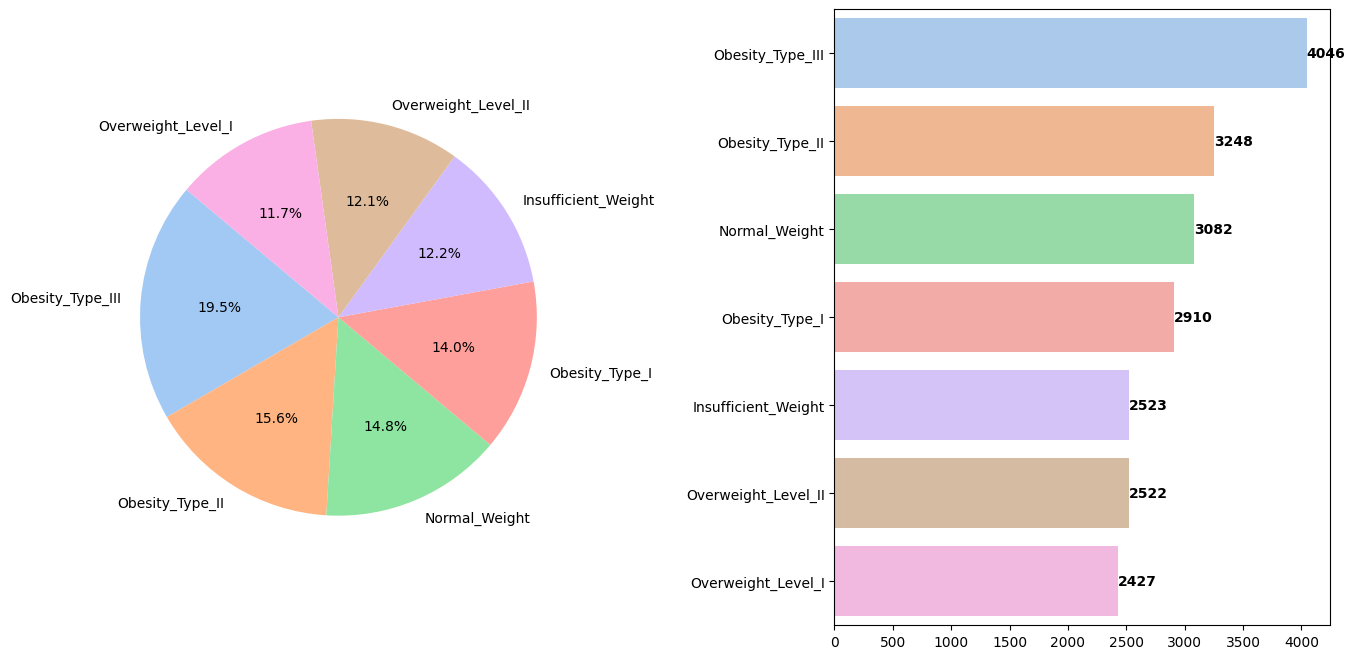

In [9]:
# Target Variable
showchart(train,"NObeyesdad")

⭐️  most heighest number of people with 

### Overity_Type III having share of 19.5% 

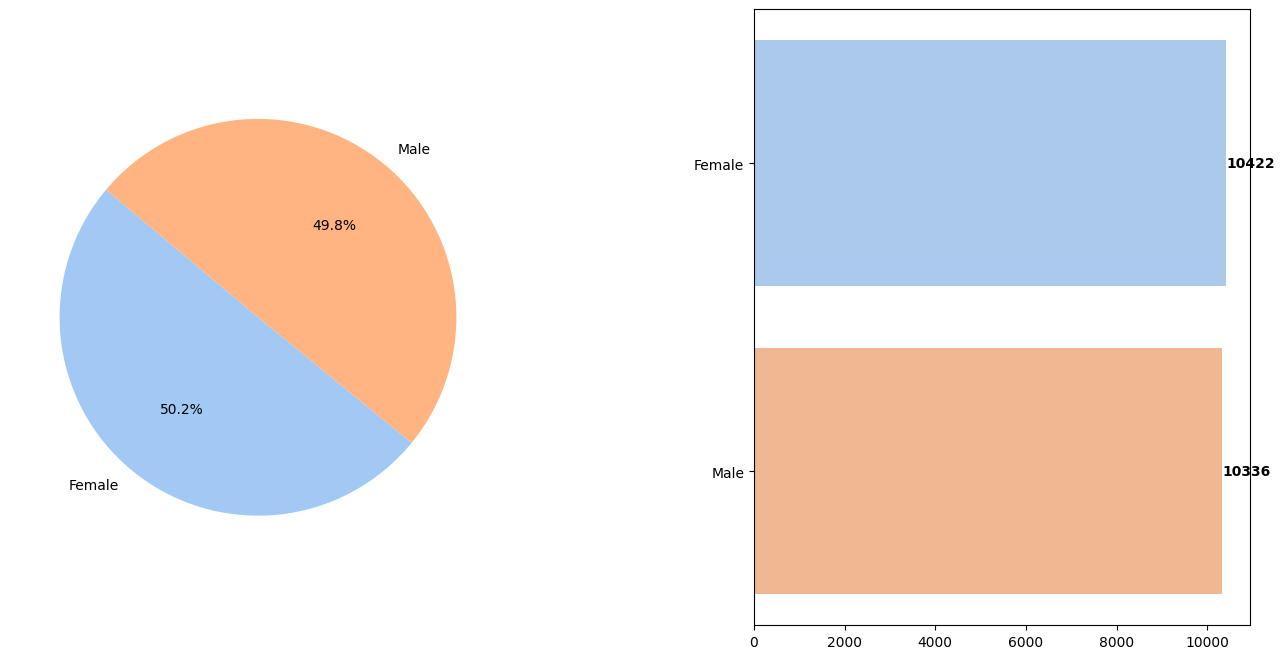

In [10]:
showchart(train, 'Gender')

⭐️  Gender distribution is fairly equal in the dataset

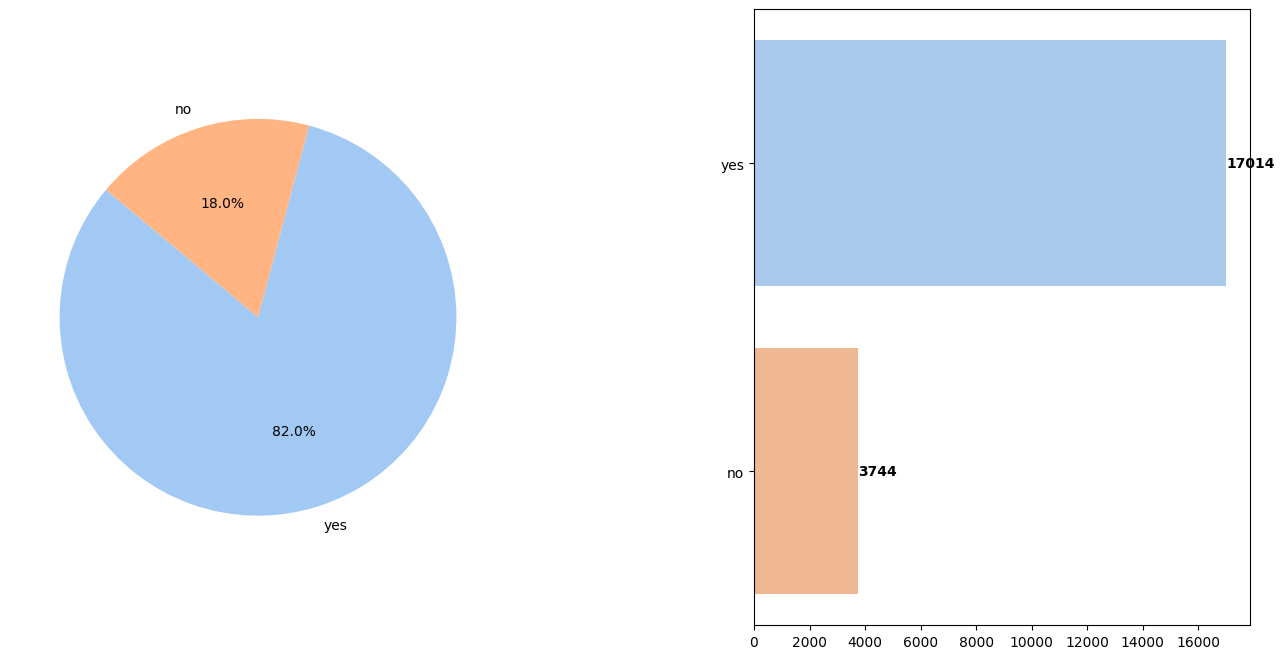

In [11]:
showchart(train, 'family_history_with_overweight')

### ⭐️ 82.0% people have a family history with overweight

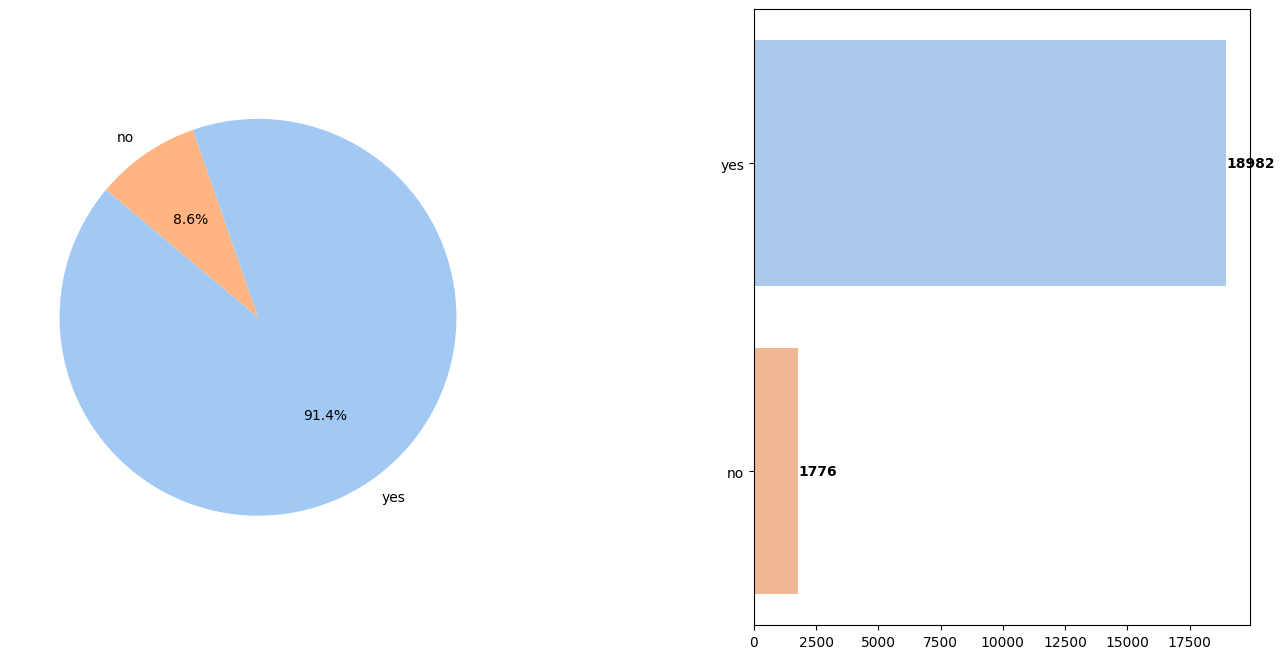

In [12]:
showchart(train, 'FAVC')

###  ⭐️ 91.4% people Frequently consume high caloric food

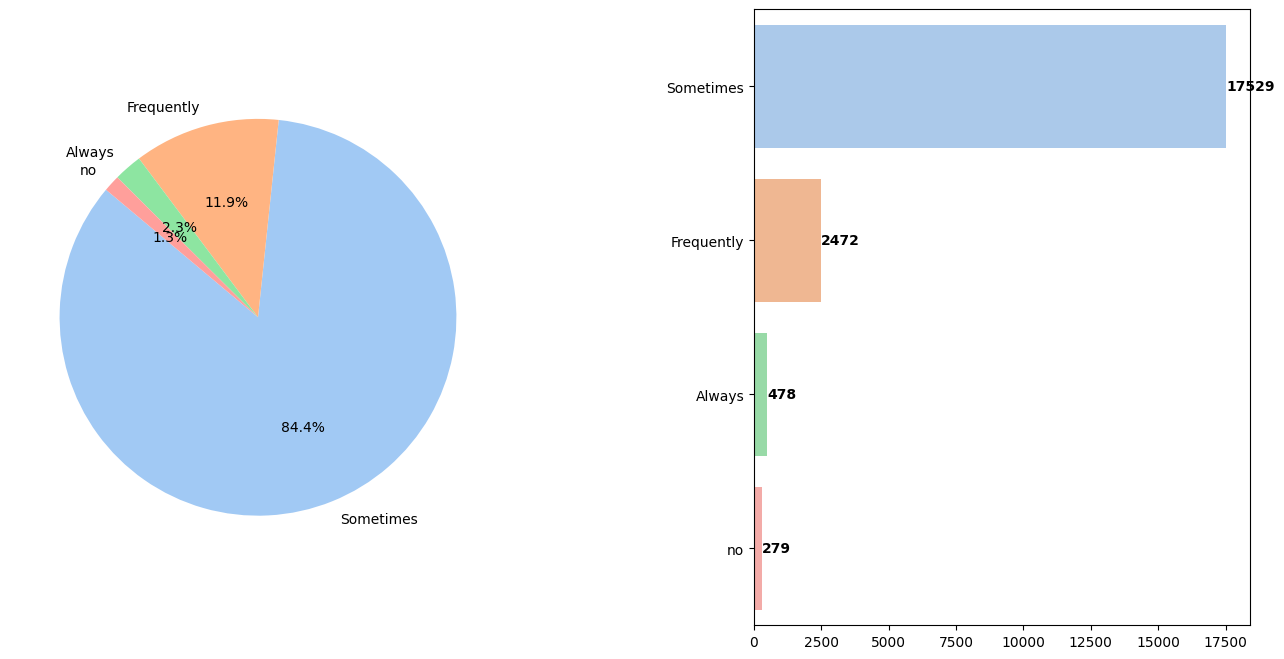

In [13]:
showchart(train, 'CAEC')

###  ⭐️ only 1.5% people say they don't consume food between meals

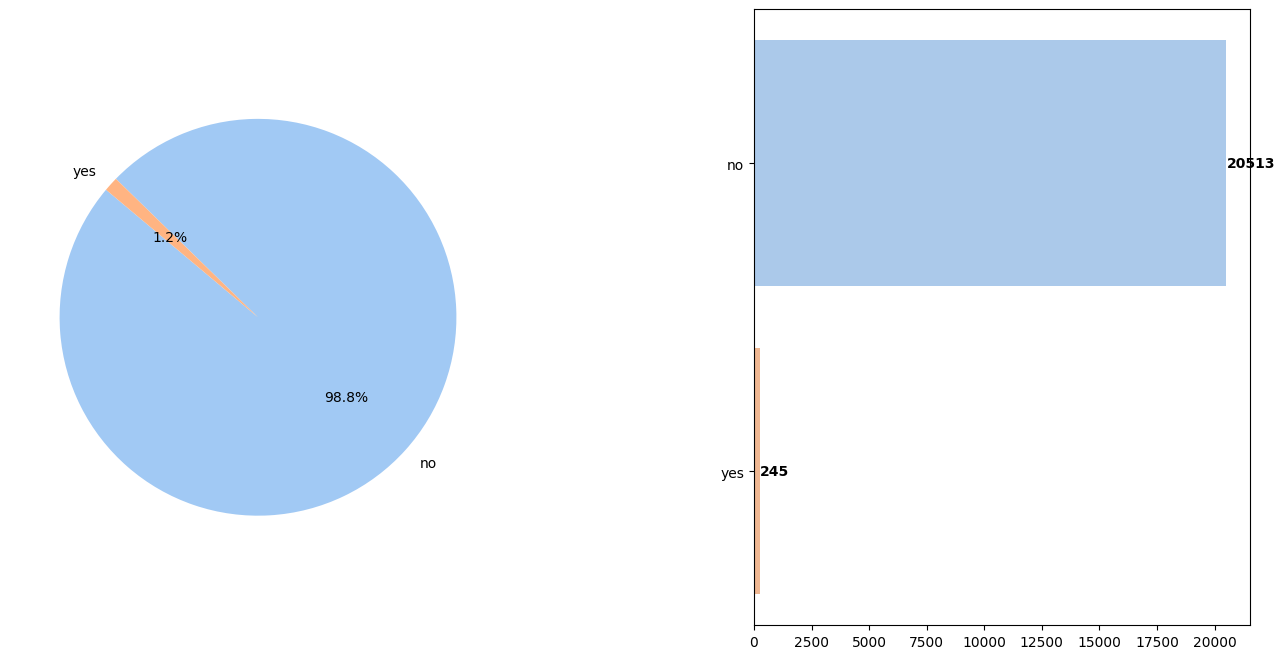

In [14]:
showchart(train, 'SMOKE')

⭐️ According the data,
### 98.8% are non-smokers.

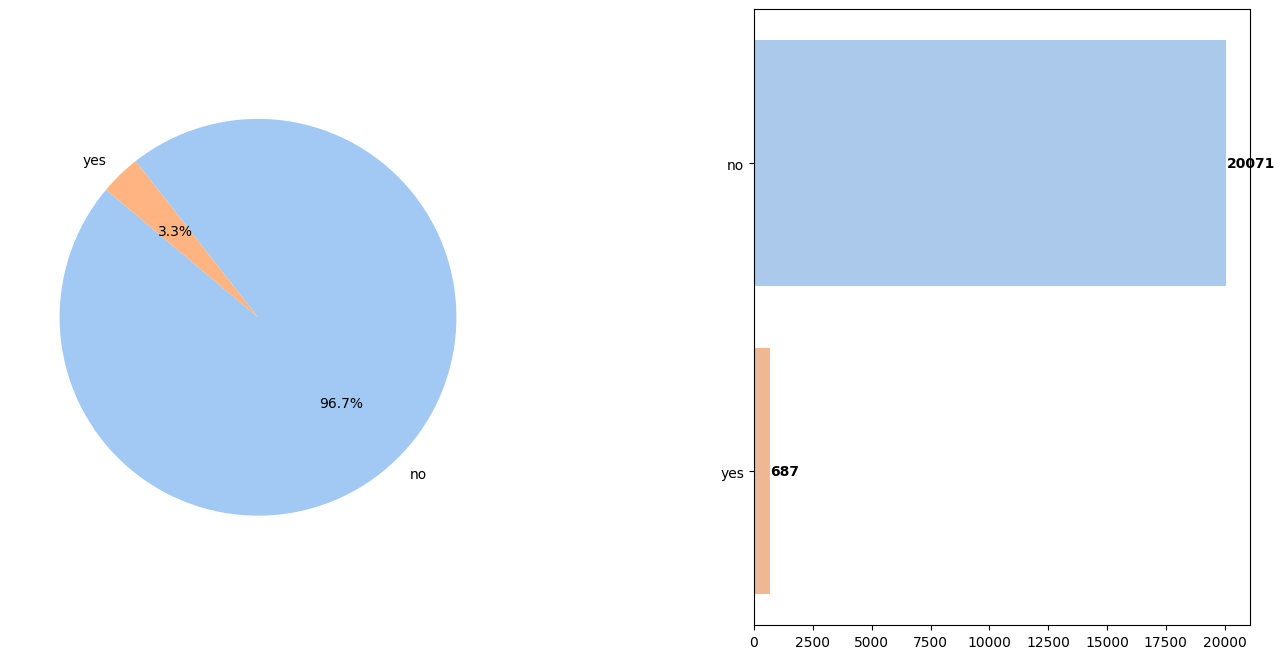

In [15]:
showchart(train, 'SCC')

### ⭐️ 96.7% don't bother monitoring calorie consumption.

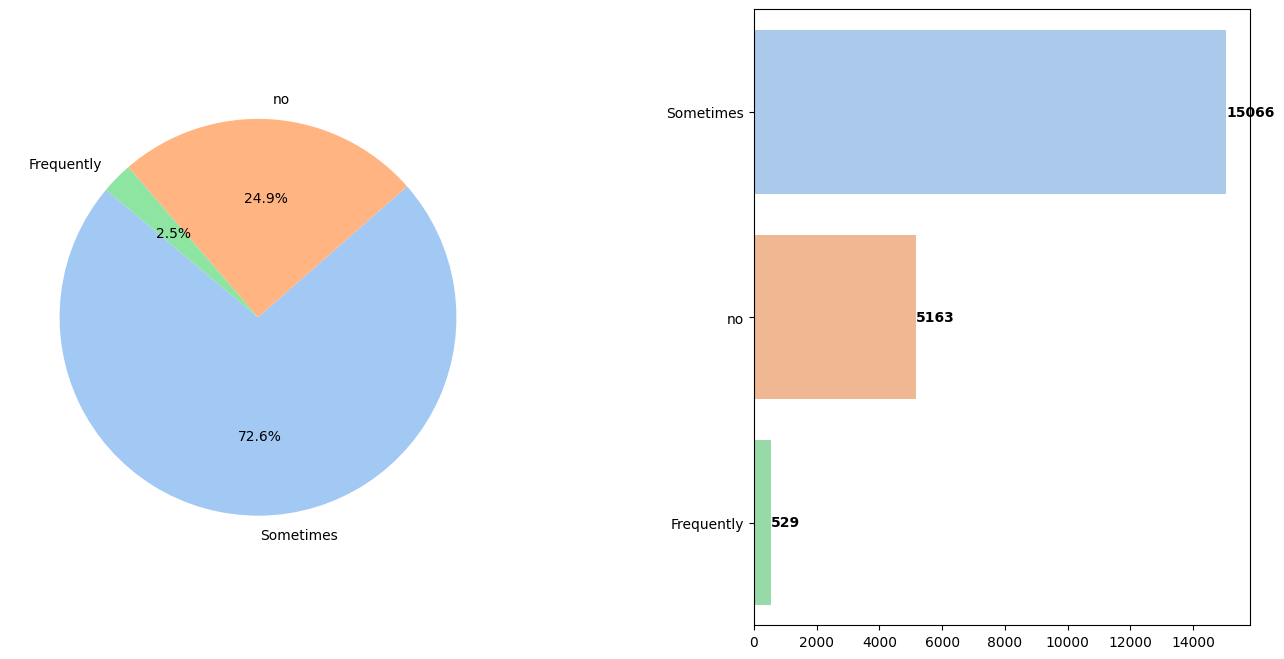

In [16]:
showchart(train, 'CALC')

### ⭐️ 72.6% consumes alcohol sometimes while 2.5% does Frequent.

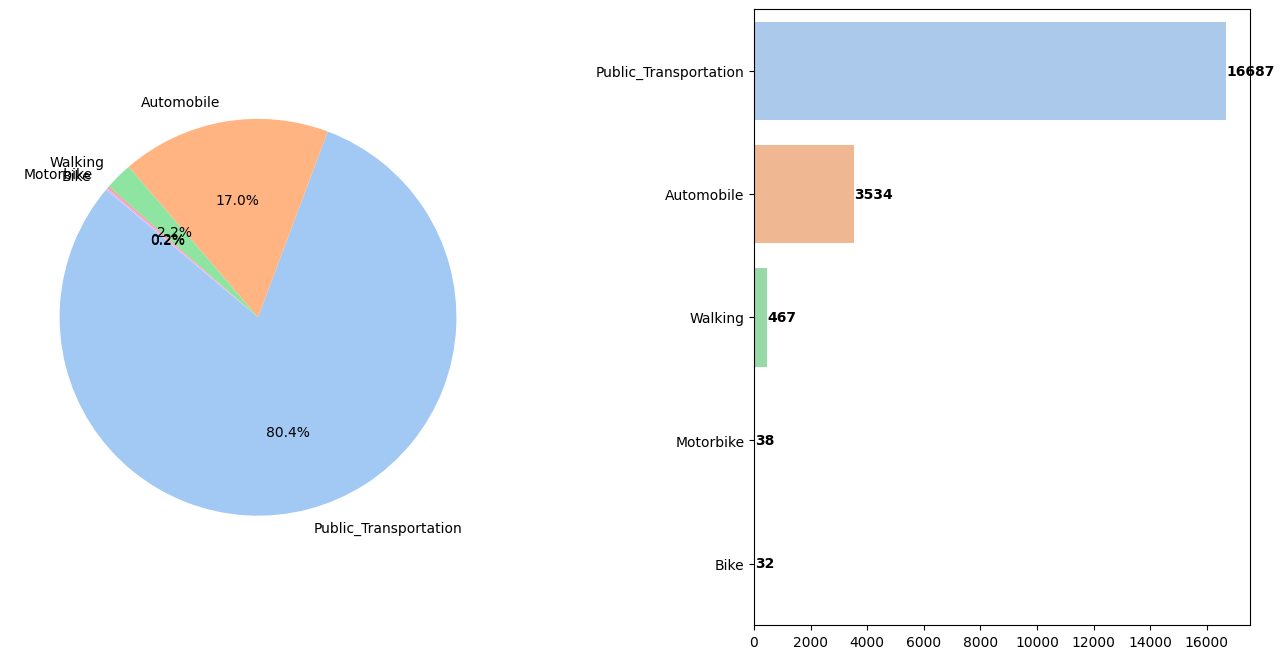

In [17]:
showchart(train, 'MTRANS')

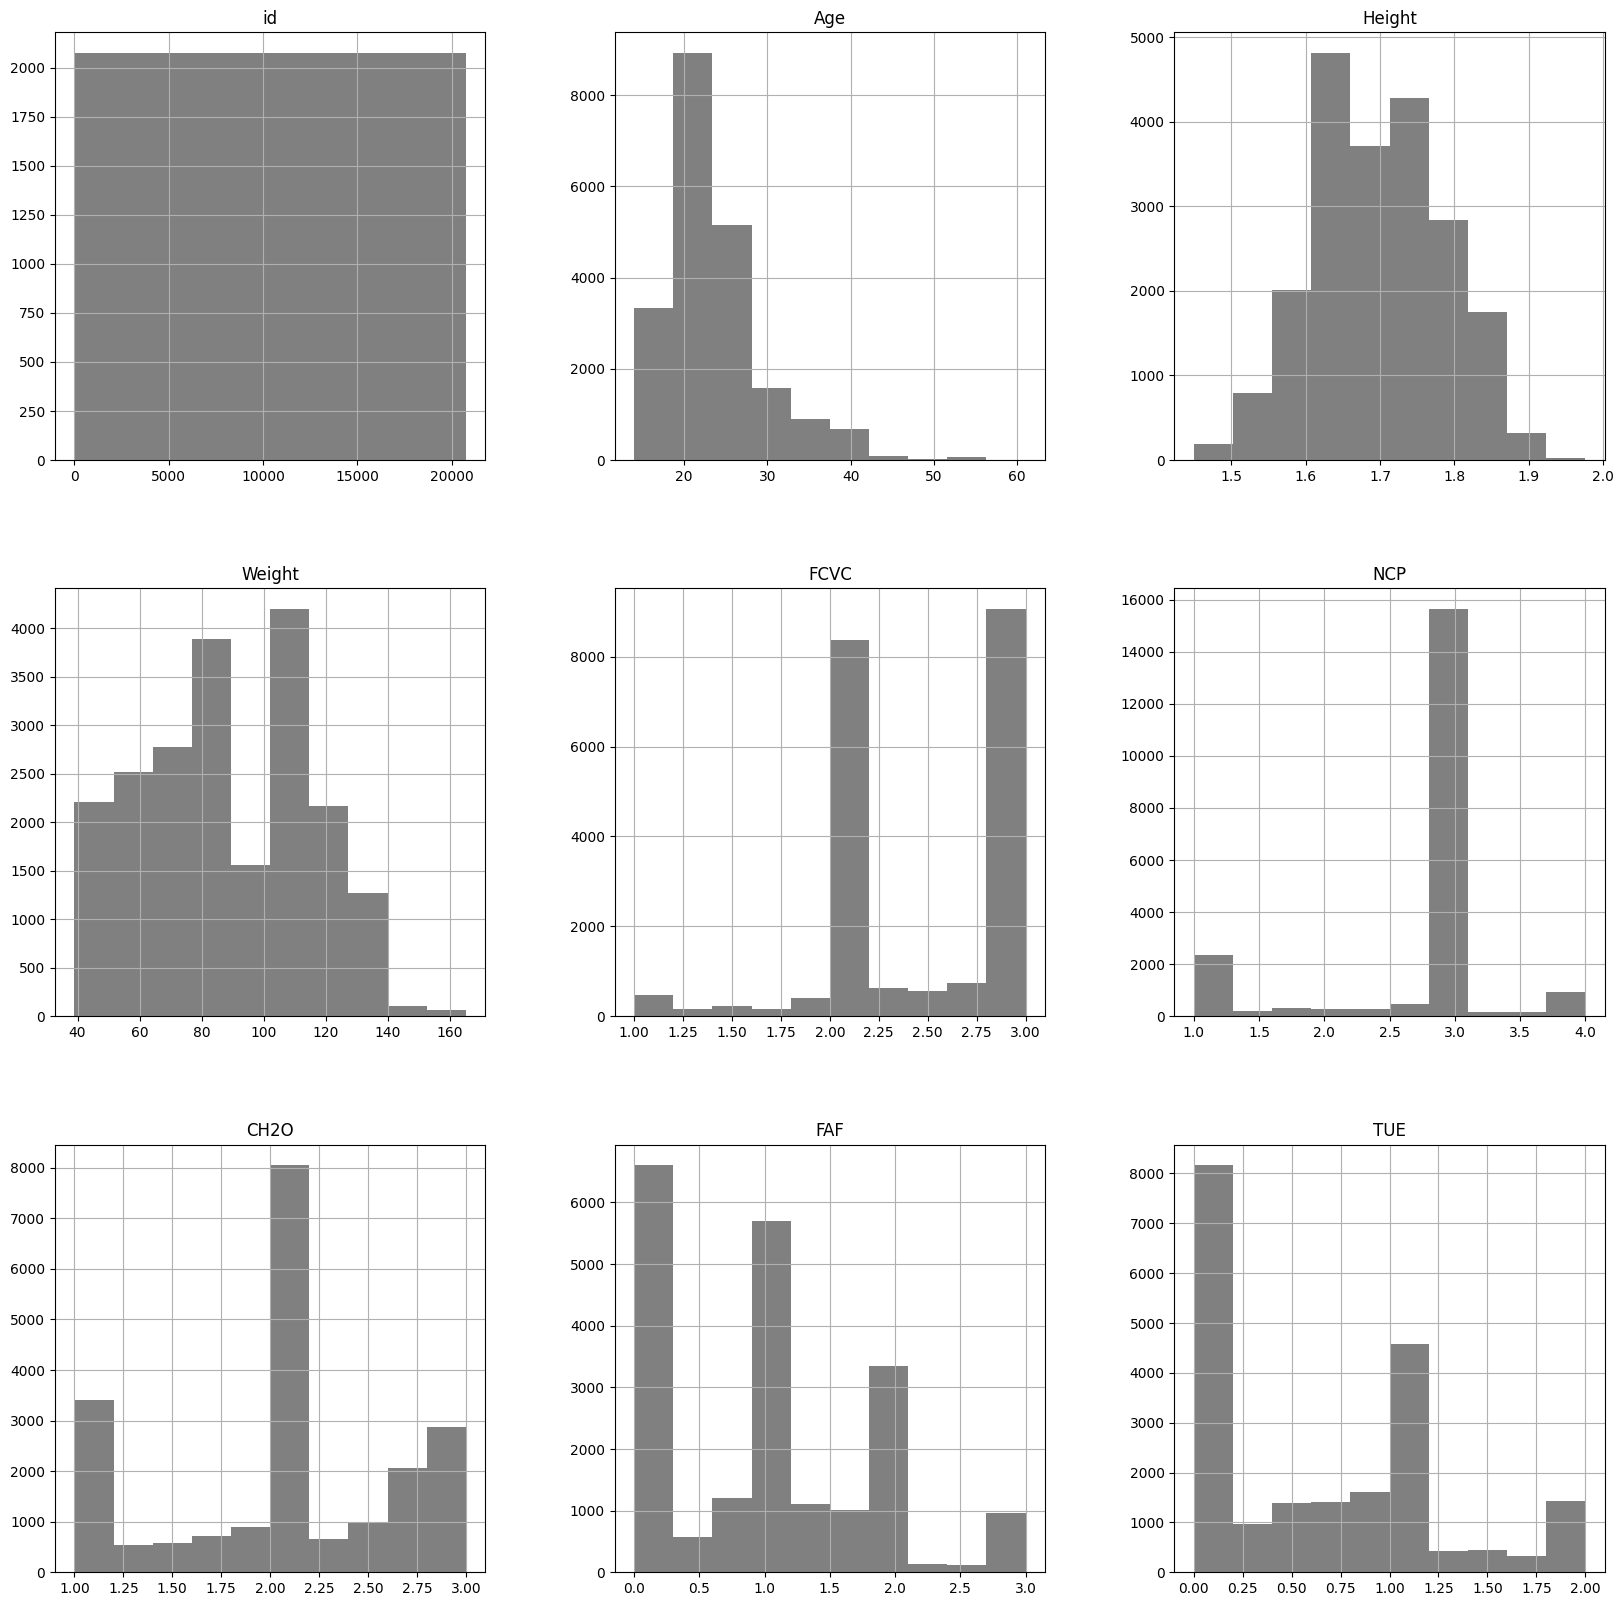

In [18]:
train.hist(figsize=(20,20), color = 'gray')
plt.show()

## More information seems to be needed. 
### I'd like to create a BMI feature and explore its relationship with other features.

In [19]:
def feature_engineering(data):
    # BMI
    data['BMI'] = data['Weight'] / (data['Height'] ** 2)
    # 'id'열 삭제
    data = data.drop(columns=['id'])
    
    return data

In [20]:
train = feature_engineering(train)
test = feature_engineering(test)

### NObeyesdad , BMI

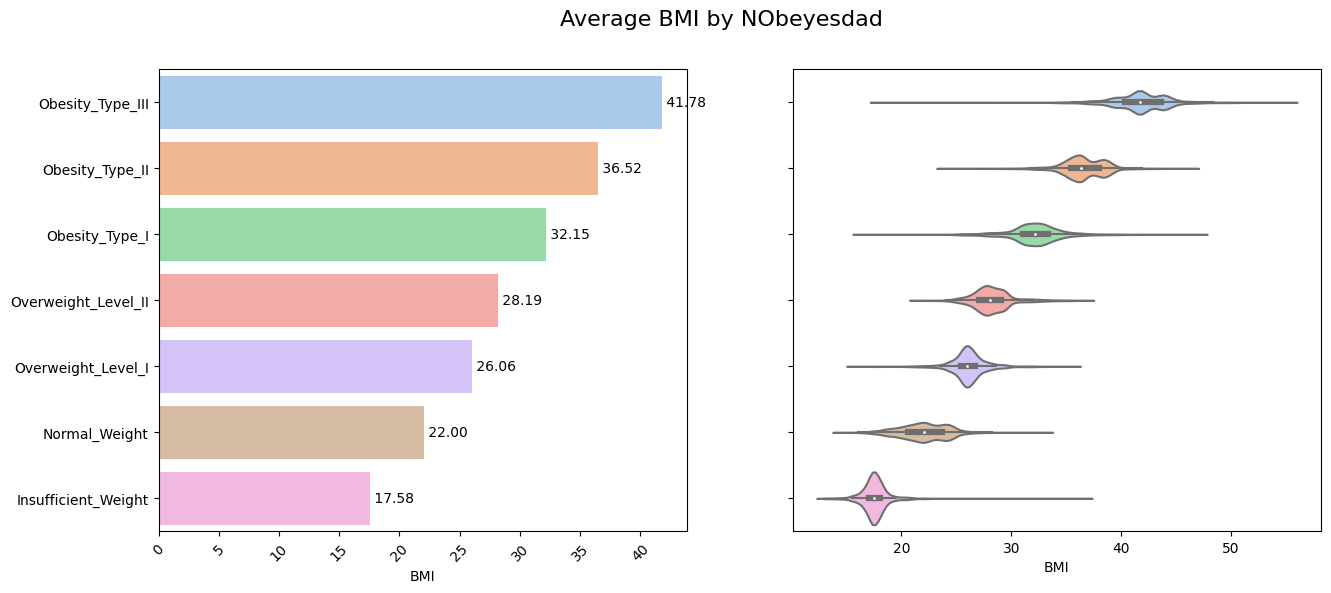

In [21]:
# NObeyesdad별 BMI의 평균 계산
nobe_bmi_mean = train.groupby('NObeyesdad')['BMI'].mean().reset_index()

# BMI값이 높은 순서대로 정렬
nobe_bmi_mean_sorted = nobe_bmi_mean.sort_values(by='BMI', ascending = False)

# 시각화
fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.barplot(y='NObeyesdad', x='BMI',ax=axes[0],data=nobe_bmi_mean,order=nobe_bmi_mean_sorted['NObeyesdad'],palette='pastel')

for index, row in enumerate(nobe_bmi_mean_sorted.iterrows()):
    axes[0].text(row[1]['BMI'], index, f"{row[1]['BMI']: .2f}", va = 'center', ha = 'left', fontsize = 10)

axes[0].set_xlabel('BMI')
axes[0].set_ylabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.violinplot(y = "NObeyesdad", x= "BMI", data= train, ax=axes[1], order=nobe_bmi_mean_sorted['NObeyesdad'],palette='pastel')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])

fig.suptitle('Average BMI by NObeyesdad', fontsize = 16)
plt.show()


### The plot suggests that there is an average BMI for each level of NObeyedad.

## However, there exists inconsistency in BMI levels within the categories❗️

In [22]:
train.groupby('NObeyesdad')['BMI'].describe().reset_index().style.background_gradient()

,NObeyesdad,count,mean,std,min,25%,50%,75%,max
0,Insufficient_Weight,2523.000000,17.583619,1.388408,12.868541,17.025801,17.506390,18.025957,36.778115
1,Normal_Weight,3082.000000,22.000999,2.194097,14.631670,20.568937,22.038567,23.661439,32.882414
2,Obesity_Type_I,2910.000000,32.154649,2.513458,16.597443,31.020408,32.121386,33.298647,46.805188
3,Obesity_Type_II,3248.000000,36.521958,2.112538,24.048460,35.436970,36.378753,38.023475,46.222483
4,Obesity_Type_III,4046.000000,41.781745,2.670789,18.178670,40.371119,41.750620,43.615233,54.997991
5,Overweight_Level_I,2427.000000,26.059270,1.768697,15.761880,25.390625,25.963757,26.672763,35.555556
6,Overweight_Level_II,2522.000000,28.192491,1.835666,21.513859,27.080170,28.020083,29.086346,36.741456


Based on the descriptive statistics, it can be observed that the BMI ranges inconsistently within each category. 
### For instance, the BMI range for Obesity_Type_III spans from 18.18 to 54.99, while for Obesity_Type_II, it ranges from 24.05 to 46.22.


이러한 경우는 이상적이지 않으며, 비만도 유형별로 일정한 범위 내에서 BMI값이 유지되어야 한다.
이러한 불일치는 데이터의 정확성 및 일관성을 의심해야함을 알려준다.
-> 일관성 확인, 이상치 처리



### Gender , BMI

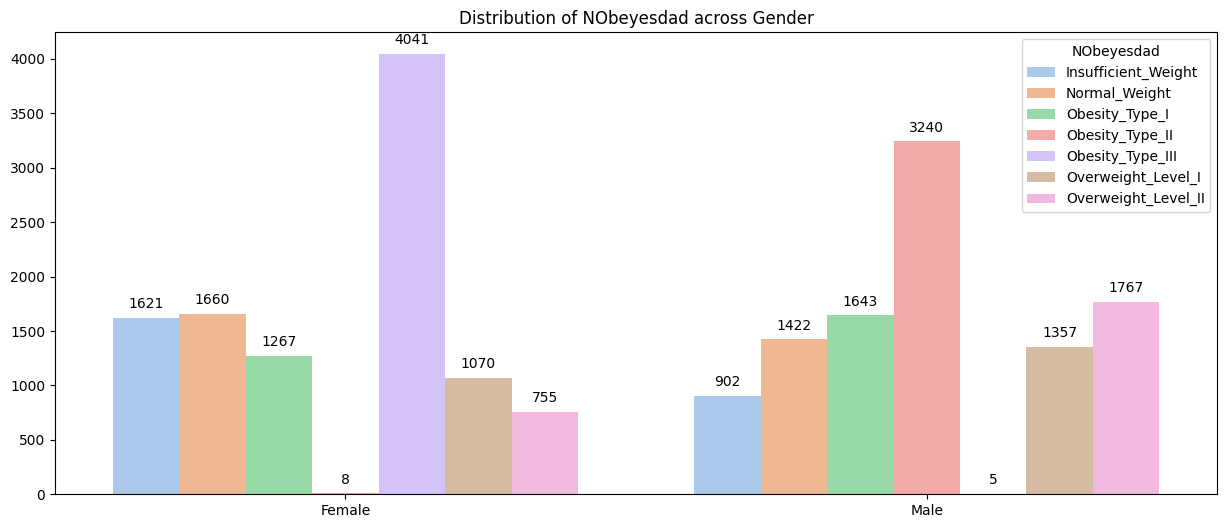

In [23]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x = "Gender", hue = "NObeyesdad", data = train, palette='pastel')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width() / 2, p.get_height()),
               ha = 'center', va = 'center',
               xytext = (0,10),
               textcoords = 'offset points')

plt.title("Distribution of NObeyesdad across Gender")
plt.xlabel('')
plt.ylabel('')


plt.show()

### Obesity Type III is predominantly observed in females,
### while Obesity Type II is predominantly observed in males.

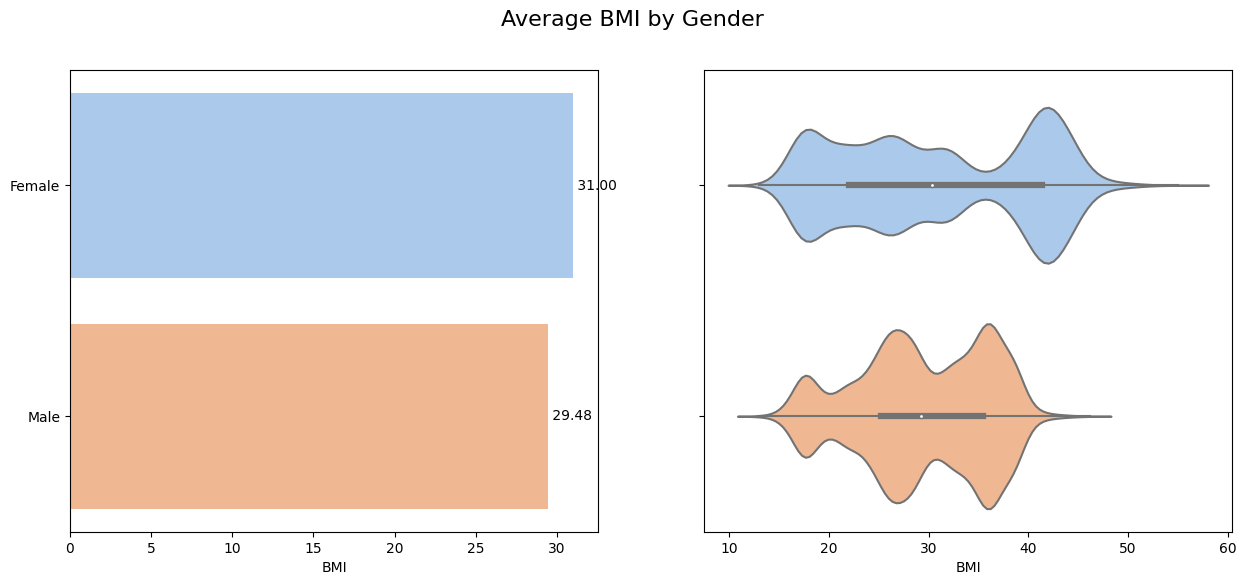

In [24]:
# Gender별 BMI의 평균 계산
gen_bmi_mean = train.groupby('Gender')['BMI'].mean().reset_index()

# BMI값이 높은 순서대로 정렬
gen_bmi_mean_sorted = gen_bmi_mean.sort_values(by='BMI', ascending = False)

# 시각화
fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.barplot(y='Gender', x='BMI',ax=axes[0],data=gen_bmi_mean,order=gen_bmi_mean_sorted['Gender'],palette='pastel')

for index, row in enumerate(gen_bmi_mean_sorted.iterrows()):
    axes[0].text(row[1]['BMI'], index, f"{row[1]['BMI']: .2f}", va = 'center', ha = 'left', fontsize = 10)

axes[0].set_xlabel('BMI')
axes[0].set_ylabel('')

sns.violinplot(y = "Gender", x= "BMI", data= train, ax=axes[1], order=gen_bmi_mean_sorted['Gender'],palette='pastel')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])

fig.suptitle('Average BMI by Gender', fontsize = 16)
plt.show()


### When viewed alongside the plot of NObeyesdad-Gender previously drawn, it can be observed that both the distribution of obesity and the BMI index are slightly higher in the female group.

### Age , BMI

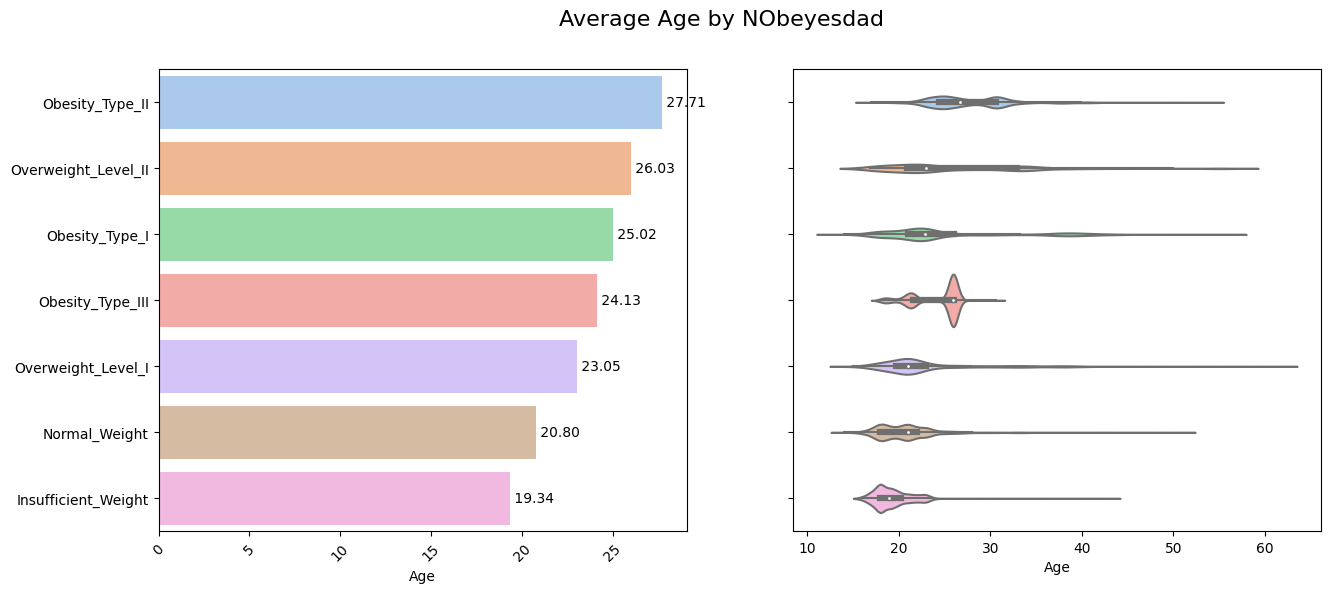

In [25]:
# NObeyesdad별 Age의 평균 계산
nobe_bmi_mean = train.groupby('NObeyesdad')['Age'].mean().reset_index()

# Age값이 높은 순서대로 정렬
nobe_bmi_mean_sorted = nobe_bmi_mean.sort_values(by='Age', ascending = False)

# 시각화
fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.barplot(y='NObeyesdad', x='Age',ax=axes[0],data=nobe_bmi_mean,order=nobe_bmi_mean_sorted['NObeyesdad'],palette='pastel')

for index, row in enumerate(nobe_bmi_mean_sorted.iterrows()):
    axes[0].text(row[1]['Age'], index, f"{row[1]['Age']: .2f}", va = 'center', ha = 'left', fontsize = 10)

axes[0].set_xlabel('Age')
axes[0].set_ylabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.violinplot(y = "NObeyesdad", x= "Age", data= train, ax=axes[1], order=nobe_bmi_mean_sorted['NObeyesdad'],palette='pastel')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])

fig.suptitle('Average Age by NObeyesdad', fontsize = 16)
plt.show()


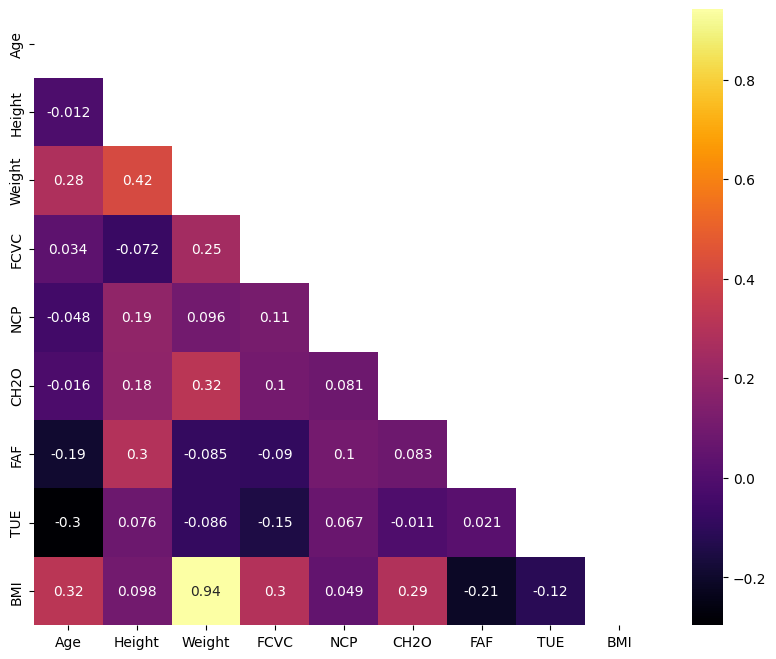

In [26]:
# Correlation matrix 계산
numeric_cols = train.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr()

# 히트맵 반만 표시
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno', mask=mask)
plt.show()


### Weight and Height has the highest positive correlation with BMI

### boxplots for outlier detection

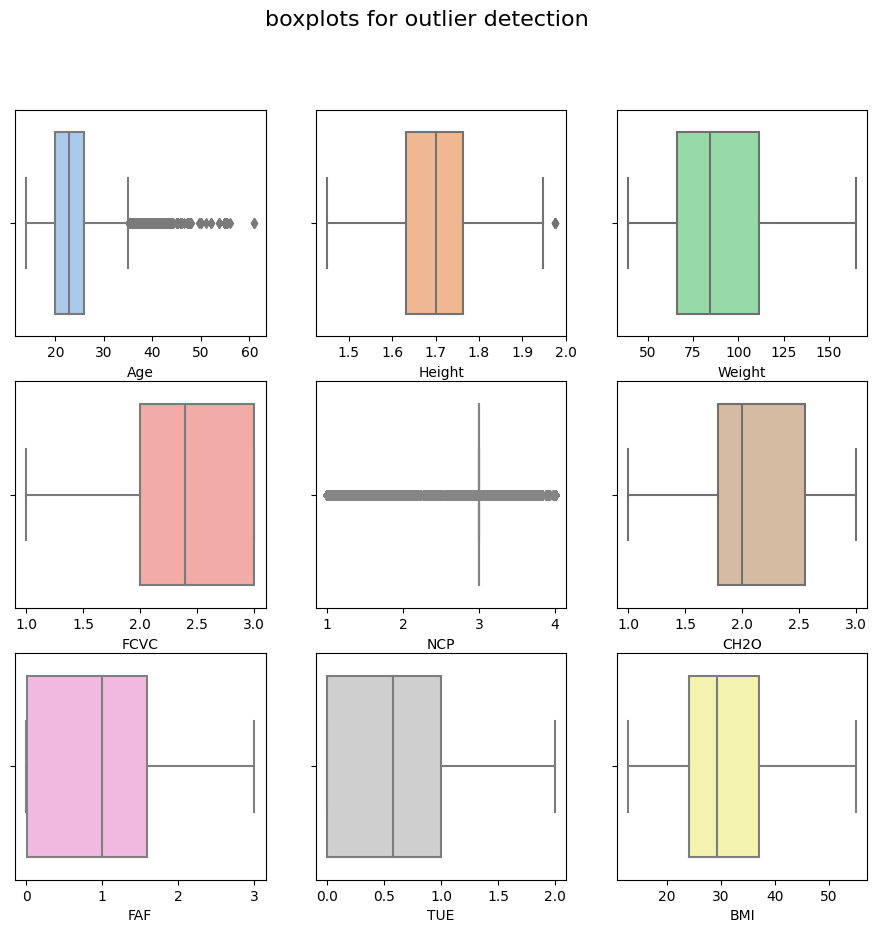

In [27]:
fig, axes = plt.subplots(3,3,figsize=(11,10))
colors = sns.color_palette('pastel', 10) 

sns.boxplot(x='Age', data=train, ax=axes[0,0],color=colors[0])
sns.boxplot(x='Height', data=train, ax=axes[0,1],color=colors[1])
sns.boxplot(x='Weight', data = train, ax=axes[0,2],color=colors[2])
sns.boxplot(x='FCVC', data = train, ax=axes[1,0],color=colors[3])
sns.boxplot(x= 'NCP', data = train, ax=axes[1,1],color=colors[4])
sns.boxplot(x= 'CH2O', data=train, ax=axes[1,2],color=colors[5])
sns.boxplot(x='FAF', data=train, ax=axes[2,0],color=colors[6])
sns.boxplot(x='TUE', data=train, ax=axes[2,1],color=colors[7])
sns.boxplot(x="BMI", data=train, ax=axes[2,2], color=colors[8])

fig.suptitle('boxplots for outlier detection', fontsize = 16)
plt.show()

- As a result of visualization, we identified that there were many outliers in the Age variable.


# 3. ML Models Building

## 3-1. RandomForest
### ▶️ Preporcessing

In [86]:
# 데이터 불러오기
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# 훈련 데이터와 타겟 데이터 분리
X_train = train.drop(columns=['NObeyesdad','id'])
y_train = train['NObeyesdad']
X_test = test.drop(columns=['id'])  # 테스트 데이터에는 타겟 데이터가 없으므로 전체 데이터를 사용합니다.

# BMI 피처 추가
X_train['BMI'] = X_train['Weight'] / (X_train['Height'] ** 2)
X_test['BMI'] = X_test['Weight'] / (X_test['Height'] ** 2)

print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [87]:
# 수치형 특성과 범주형 특성 선택
train_numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
train_categorical_features = X_train.select_dtypes(include = ['object']).columns

test_numeric_features = X_test.select_dtypes(include=['float64', 'int64']).columns
test_categorical_features = X_test.select_dtypes(include =['object']).columns

# 수치형 특성 전처리
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[train_numeric_features])
X_test_numeric = scaler.transform(X_test[test_numeric_features])

# 범주형 특성 전처리
encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(X_train[train_categorical_features])
X_test_categorical = encoder.transform(X_test[test_categorical_features])

# 전처리 된 특성 결합
X_train_processed = pd.DataFrame(X_train_numeric, columns=train_numeric_features)
X_train= pd.concat([X_train_processed, pd.DataFrame(X_train_categorical.toarray(), columns=encoder.get_feature_names_out(train_categorical_features))], axis=1)

X_test_processed = pd.DataFrame(X_test_numeric, columns=test_numeric_features)
X_test = pd.concat([X_test_processed, pd.DataFrame(X_test_categorical.toarray(), columns=encoder.get_feature_names_out(test_categorical_features))], axis = 1)

# 학습 데이터와 검증 데이터 분리
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train_split.shape)
print(X_val.shape)


(16606, 23)
(4152, 23)


In [88]:
# 모델 정의
rf_model = RandomForestClassifier(random_state=42)

# 학습 시작 시간 기록
start_time = time.time()

# 머신 러닝 모델 학습
rf_model.fit(X_train_split, y_train_split)

# 학습 종료 시간 기록
end_time = time.time()
# 학습 시간 계산
training_time = end_time - start_time
print(f'학습 및 튜닝 시간 : {training_time:.2f}초')

# 검증 데이터에 대한 예측
y_pred_val = rf_model.predict(X_val)

# 검증 데이터에 대한 성능 평가
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='weighted')
recall = recall_score(y_val, y_pred_val, average='weighted')
f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# classification report
print('Classification Report : ')
print(classification_report(y_val, y_pred_val))



학습 및 튜닝 시간 : 2.50초
Accuracy: 0.898121387283237
Precision: 0.8984188647621038
Recall: 0.898121387283237
F1 Score: 0.8982397734914874
Classification Report : 
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.93      0.93       524
      Normal_Weight       0.87      0.88      0.87       626
     Obesity_Type_I       0.88      0.87      0.88       543
    Obesity_Type_II       0.98      0.98      0.98       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.75      0.77      0.76       484
Overweight_Level_II       0.79      0.78      0.79       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



### ▶️Hyperparameter tuning


In [89]:
# 모델 정의
rf_model = RandomForestClassifier(random_state=42)

# 탐색할 하이퍼파라미터 분포 설정
param_dist = {
    'n_estimators' : np.arange(50,200,10),
    'max_depth' : [None, 5, 10, 20],
    'min_samples_split' : np.arange(2,20),
    'min_samples_leaf' : np.arange(1,10)
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions = param_dist, n_iter=30, cv = 5, scoring='accuracy', n_jobs = 1,random_state =121 )

#랜덤 서치 수행
random_search.fit(X_train_split, y_train_split)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터 : ", random_search.best_params_)
print('최적의 성능 : ', random_search.best_score_)

# 학습 시작 시간 기록
start_time = time.time()

# 최적의 하이퍼파라미터로 모델 재학습
rf_best = RandomForestClassifier(**random_search.best_params_)
rf_best.fit(X_train_split, y_train_split)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 시간 계산
training_time = end_time - start_time
print(f'학습 시간 : {training_time:.2f}초')

# 검증 데이터에 대한 예측
y_pred_val = rf_best.predict(X_val)

# 검증 데이터에 대한 성능 평가
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='weighted')
recall = recall_score(y_val, y_pred_val, average='weighted')
f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# classification report
print('Classification Report : ')
print(classification_report(y_val, y_pred_val))

최적의 하이퍼파라미터 :  {'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
최적의 성능 :  0.900638847782551
학습 시간 : 2.97초
Accuracy: 0.9029383429672447
Precision: 0.9031183300203615
Recall: 0.9029383429672447
F1 Score: 0.9029798173702266
Classification Report : 
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.94      0.94       524
      Normal_Weight       0.87      0.89      0.88       626
     Obesity_Type_I       0.88      0.87      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.77      0.78      0.78       484
Overweight_Level_II       0.81      0.79      0.80       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



### ▶️ cross-validation


In [32]:
# 모델 정의
rf_model = RandomForestClassifier(n_estimators= 120, min_samples_split= 5,min_samples_leaf=1,max_depth= None,random_state=42)

# StratifiedKFold 생성
skf = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)

# 교차 검증 수행
cv_scores = cross_val_score(rf_model, X_train_split, y_train_split, cv=skf)

# 교차 검증 결과 출력
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.89464178 0.89641674 0.90665462 0.90635351 0.8955134 ]


### ▶️ ensemble
I've figured out the best hyperparameters for the GradientBoostingClassifier using the same approach.

In [34]:
# 모델 정의
gbm_model = GradientBoostingClassifier(random_state=42)

# 탐색할 하이퍼파라미터 분포 설정
param_dist = {
    'n_estimators' : np.arange(50,200,10),
    'max_depth' : [None, 5, 10, 20],
    'min_samples_split' : np.arange(2,20),
    'min_samples_leaf' : np.arange(1,10)
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions = param_dist, n_iter=30, cv = 3, scoring='accuracy', n_jobs = 1,random_state =121 )

#랜덤 서치 수행
random_search.fit(X_train_split, y_train_split)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터 : ", random_search.best_params_)
print('최적의 성능 : ', random_search.best_score_)

# 학습 시작 시간 기록
start_time = time.time()

# 최적의 하이퍼파라미터로 모델 재학습
gbm_best = GradientBoostingClassifier(**random_search.best_params_)
gbm_best.fit(X_train_split, y_train_split)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 시간 계산
training_time = end_time - start_time
print(f'학습 시간 : {training_time:.2f}초')

# 검증 데이터에 대한 예측
y_pred_val = rf_best.predict(X_val)

# 검증 데이터에 대한 성능 평가
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='weighted')
recall = recall_score(y_val, y_pred_val, average='weighted')
f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# classification report
print('Classification Report : ')
print(classification_report(y_val, y_pred_val))

최적의 하이퍼파라미터 :  {'n_estimators': 120, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_depth': 20}
최적의 성능 :  0.8999160840195429
학습 시간 : 173.30초
Accuracy: 0.904383429672447
Precision: 0.9045449997557237
Recall: 0.904383429672447
F1 Score: 0.9044244868094137
Classification Report : 
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.93      0.94       524
      Normal_Weight       0.87      0.89      0.88       626
     Obesity_Type_I       0.89      0.88      0.88       543
    Obesity_Type_II       0.97      0.98      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.78      0.78      0.78       484
Overweight_Level_II       0.80      0.80      0.80       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



In [36]:
# 모델 정의
rf_model = RandomForestClassifier(n_estimators= 120, min_samples_split= 5, min_samples_leaf=1, max_depth=None, random_state=42)
gbm_model = GradientBoostingClassifier(n_estimators= 120, min_samples_split = 11,min_samples_leaf = 1, max_depth =20,random_state=42)

# 앙상블 모델 정의
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('gbm', gbm_model)], voting ='soft')

# 학습 시작 시간 기록
start_time = time.time()

# 앙상블 모델 학습
ensemble_model.fit(X_train_split, y_train_split)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 및 튜닝 시간 계산
training_time = end_time - start_time
print(f'학습 및 튜닝 시간 : {training_time:.2f}초')

#검증 데이터에 대한 예측
ensemble_pred = ensemble_model.predict(X_val)

# 앙상블 모델 성능 평가
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)
precision = precision_score(y_val, ensemble_pred, average='weighted')
recall = recall_score(y_val, ensemble_pred, average='weighted')
f1 = f1_score(y_val, ensemble_pred, average='weighted')

print("Accuracy:", ensemble_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# classification report
print('Classification Report : ')
print(classification_report(y_val, ensemble_pred))


학습 및 튜닝 시간 : 182.20초
Accuracy: 0.8954720616570327
Precision: 0.8954704936805654
Recall: 0.8954720616570327
F1 Score: 0.8954388190392615
Classification Report : 
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.93       524
      Normal_Weight       0.87      0.87      0.87       626
     Obesity_Type_I       0.87      0.87      0.87       543
    Obesity_Type_II       0.97      0.98      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.75      0.77      0.76       484
Overweight_Level_II       0.79      0.77      0.78       514

           accuracy                           0.90      4152
          macro avg       0.88      0.88      0.88      4152
       weighted avg       0.90      0.90      0.90      4152



In [37]:
# 모델 정의
rf_model = RandomForestClassifier(n_estimators= 120, min_samples_split= 5, min_samples_leaf=1, max_depth=None, random_state=42)
gbm_model = GradientBoostingClassifier(n_estimators= 120, min_samples_split = 11,min_samples_leaf = 1, max_depth =20,random_state=42)

# 앙상블 모델 정의
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('gbm', gbm_model)], voting ='hard')

# 학습 시작 시간 기록
start_time = time.time()

# 앙상블 모델 학습
ensemble_model.fit(X_train_split, y_train_split)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 및 튜닝 시간 계산
training_time = end_time - start_time
print(f'학습 및 튜닝 시간 : {training_time:.2f}초')

#검증 데이터에 대한 예측
ensemble_pred = ensemble_model.predict(X_val)

# 앙상블 모델 성능 평가
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)
precision = precision_score(y_val, ensemble_pred, average='weighted')
recall = recall_score(y_val, ensemble_pred, average='weighted')
f1 = f1_score(y_val, ensemble_pred, average='weighted')

print("Accuracy:", ensemble_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# classification report
print('Classification Report : ')
print(classification_report(y_val, ensemble_pred))


학습 및 튜닝 시간 : 177.43초
Accuracy: 0.8964354527938343
Precision: 0.8965249072985932
Recall: 0.8964354527938343
F1 Score: 0.8959431790621708
Classification Report : 
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.94      0.93       524
      Normal_Weight       0.86      0.88      0.87       626
     Obesity_Type_I       0.85      0.89      0.87       543
    Obesity_Type_II       0.98      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.76      0.78      0.77       484
Overweight_Level_II       0.83      0.73      0.78       514

           accuracy                           0.90      4152
          macro avg       0.89      0.88      0.88      4152
       weighted avg       0.90      0.90      0.90      4152



In [90]:
# 모델 정의
rf_model = RandomForestClassifier(n_estimators=120, min_samples_split=5, min_samples_leaf=1, max_depth=None, random_state=42)

# 훈련 데이터 학습
rf_model.fit(X_train_split, y_train_split)

# 테스트 데이터 예측
preds = rf_model.predict(X_test)

submission = pd.DataFrame({'id':test.id, 'NObeyesdad': preds})
print(submission)

          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759   Overweight_Level_I
2      20760     Obesity_Type_III
3      20761       Obesity_Type_I
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593  Overweight_Level_II
13836  34594        Normal_Weight
13837  34595  Insufficient_Weight
13838  34596        Normal_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


## 3-2. XGBoost

In [91]:
train = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

### ▶️ Feature Engineering & Encoding

In [92]:
train['BMI'] = train['Weight'] / (train['Height']**2)
test['BMI'] = test['Weight'] / (test['Height']**2)

train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

print(train.head(1))

  Gender        Age    Height    Weight family_history_with_overweight FAVC  \
0   Male  24.443011  1.699998  81.66995                            yes  yes   

   FCVC       NCP       CAEC SMOKE      CH2O SCC  FAF       TUE       CALC  \
0   2.0  2.983297  Sometimes    no  2.763573  no  0.0  0.976473  Sometimes   

                  MTRANS           NObeyesdad        BMI  
0  Public_Transportation  Overweight_Level_II  28.259565  


In [93]:
caec_mapping = {'no': 0, 
                'Sometimes': 1, 
                'Frequently': 2, 
                'Always': 3}

calc_mapping = {'no': 0, 
                'Sometimes': 1, 
                'Frequently': 2}

mtrans_mapping = {'Walking': 4, 
                  'Bike': 3, 
                  'Public_Transportation': 2, 
                  'Motorbike': 1, 
                  'Automobile': 0}

nobeyesdad_mapping = {'Insufficient_Weight': 0, 
                      'Normal_Weight': 1, 
                      'Overweight_Level_I': 2, 
                      'Overweight_Level_II': 3, 
                      'Obesity_Type_I': 4, 
                      'Obesity_Type_II': 5, 
                      'Obesity_Type_III': 6}

gender_mapping = {'Female': 0, 'Male': 1}

train['CAEC'] = train['CAEC'].map(caec_mapping)
test['CAEC'] = test['CAEC'].map(caec_mapping)
train['CALC'] = train['CALC'].map(calc_mapping)
test['CALC'] = test['CALC'].map(calc_mapping)
train['MTRANS'] = train['MTRANS'].map(mtrans_mapping)
test['MTRANS'] = test['MTRANS'].map(mtrans_mapping)
train['NObeyesdad'] = train['NObeyesdad'].map(nobeyesdad_mapping)
train['Gender'] = train['Gender'].map(gender_mapping)
test['Gender'] = test['Gender'].map(gender_mapping)

### ▶️ Data Preprocessing and Modeling Pipeline

In [94]:
categorical_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
numerical_features = train.columns.drop(['NObeyesdad'] + categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), 
        ('cat', OneHotEncoder(), categorical_features) 
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        subsample=0.7,
        n_estimators=900,
        max_depth=4,
        learning_rate=0.03,
        colsample_bytree=0.5,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ))
])

In [95]:
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16606, 17), (4152, 17), (16606,), (4152,))

In [96]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [98]:
pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Gender', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O',
       'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  ['family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, cal...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=900, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### ▶️ Cross-Validation

In [99]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=cv, scoring='accuracy')
scores

array([0.90698374, 0.90213791, 0.91177356, 0.91117133, 0.90876242])

In [100]:
inverse_nobeyesdad_mapping = {v: k for k, v in nobeyesdad_mapping.items()}
inverse_nobeyesdad_mapping

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Overweight_Level_I',
 3: 'Overweight_Level_II',
 4: 'Obesity_Type_I',
 5: 'Obesity_Type_II',
 6: 'Obesity_Type_III'}

In [101]:
preds = pipeline.predict(test)

test_preds_labels = [inverse_nobeyesdad_mapping[pred] for pred in preds]
submission['NObeyesdad'] =test_preds_labels
submission

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


## 3-3. CatBoost

In [75]:
# Set Prameters for Reproduciblity
pd.set_option("display.max_rows",100)
TARGET = "NObeyesdad"
n_splits = 10
RANDOM_SEED = 43

In [76]:
# load all data
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
train_org = pd.read_csv('/kaggle/input/obesity-levels/ObesityDataSet_raw_and_data_sinthetic.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

#Combine Orignal & Synthetic Data
train.drop(['id'],axis = 1, inplace = True)
test_ids = test['id']
test.drop(['id'],axis = 1, inplace=True)

train = pd.concat([train,train_org],axis = 0)
train = train.drop_duplicates()
train.reset_index(drop=True, inplace=True)

# Train Data
print("Train Data")
print(f"Total number of rows: {len(train)}")
print(f"Total number of columns: {train.shape[1]}\n")

# Test Data
print("Test Data")
print(f"Total number of rows: {len(test)}")
print(f"Total number of columns:{test.shape[1]}")

Train Data
Total number of rows: 22845
Total number of columns: 17

Test Data
Total number of rows: 13840
Total number of columns:16


### ▶️ Preporcessing

In [77]:
raw_num_cols = list(train.select_dtypes("float").columns) 
raw_cat_cols = list(train.columns.drop(raw_num_cols+[TARGET]))

# In age_rounder, height_rounder func we multiply values
# by some value this sometimes improve model CV score
# In Extract features we combine features to get new features

def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age']*100).astype(np.uint16)
    return x_copy

def height_rounder(x):
    x_copy = x.copy()
    x_copy['Height'] = (x_copy['Height']*100).astype(np.uint16)
    return x_copy

def extract_features(x):
    x_copy = x.copy()
    x_copy['BMI'] = (x_copy['Weight']/x_copy['Height']**2)
#     x_copy['PseudoTarget'] = pd.cut(x_copy['BMI'],bins = [0,18.4,24.9,29,34.9,39.9,100],labels = [0,1,2,3,4,5],)    
    return x_copy

def col_rounder(x):
    x_copy = x.copy()
    cols_to_round = ['FCVC',"NCP","CH2O","FAF","TUE"]
    for col in cols_to_round:
        x_copy[col] = round(x_copy[col])
        x_copy[col] = x_copy[col].astype('int')
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)
HeightRounder = FunctionTransformer(height_rounder)
ExtractFeatures = FunctionTransformer(extract_features)
ColumnRounder = FunctionTransformer(col_rounder)



### ▶️ Cross-Validation

In [78]:
# In cross_val_model we cross vaidate models using
# Stratified K-Fold.

# Encoding target values with int
target_mapping = {
                  'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3, 
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5 ,
                  'Obesity_Type_III':6
                  }

# Define a method for Cross validation here we are using StartifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

def cross_val_model(estimators,cv = skf, verbose = True):
    '''
        estimators : pipeline consists preprocessing, encoder & model
        cv : Method for cross validation (default: StratifiedKfold)
        verbose : print train/valid score (yes/no)
    '''
    
    X = train.copy()
    y = X.pop(TARGET)

    y = y.map(target_mapping)
    test_predictions = np.zeros((len(test),7))
    valid_predictions = np.zeros((len(X),7))

    val_scores, train_scores = [],[]
    
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)
        #define train set
        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]
        #define valid set
        X_valid = X.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]

        model.fit(X_train, y_train)
        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")
            print(f"Train Accuracy Score:-{accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}")
            print(f"Valid Accuracy Score:-{accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")
            print("-" * 100)
            
        test_predictions += model.predict_proba(test)/cv.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    if verbose: 
        print(f"Average Mean Accuracy Score:- {np.array(val_scores).mean()}")
    return val_scores, valid_predictions, test_predictions

In [79]:
# empty dataframe to store score, & train / test predictions.
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [80]:
# Optuna Function For Catboost Model
def cat_objective(trial):
    
    params = {
        
        'iterations': 1000,  # High number of estimators
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU"
    }
    
    cat_features = ['Gender','family_history_with_overweight','FAVC','FCVC','NCP',
                'CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']
    optuna_model = make_pipeline(
                        ExtractFeatures,
#                         AgeRounder,
#                         HeightRounder,
#                         MEstimateEncoder(cols = raw_cat_cols),
                        CatBoostClassifier(**params,cat_features=cat_features)
                        )
    val_scores,_,_ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

cat_study = optuna.create_study(direction = 'maximize')

[I 2024-03-06 02:05:43,780] A new study created in memory with name: no-name-dd2cd327-58c2-4514-b375-df6d8681aa0c


In [81]:
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')

In [82]:
params = {'learning_rate': 0.13762007048684638, 'depth': 5, 
          'l2_leaf_reg': 5.285199432056192, 'bagging_temperature': 0.6029582154263095,
         'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"CPU",
         'iterations':1000}


CB = make_pipeline(
                         ExtractFeatures,
#                         AgeRounder,
#                         HeightRounder,
#                         MEstimateEncoder(cols = raw_cat_cols),
#                         CatBoostEncoder(cols = cat_features),
                        CatBoostClassifier(**params, cat_features=categorical_columns)
                        )

In [83]:
# Train Catboost Model
val_scores,val_predictions,test_predictions = cross_val_model(CB)
for k,v in target_mapping.items():
    oof_list[f"cat_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"cat_{k}"] = test_predictions[:,v]
    
# best average scroe : 0.9114915289311621 without extract features, n_splits = 10
# best average scroe : 0.9119292806585244 with extract features, n_splits = 10

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9422665369649805
Valid Accuracy Score:-0.9015317286652079
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.942363813229572
Valid Accuracy Score:-0.9045951859956236
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9410992217898833
Valid Accuracy Score:-0.9067833698030635
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy S

In [84]:
# 컬럼명 수정
predict_list.columns = [col.replace('cat_', '') for col in predict_list.columns]

# 예측 결과 생성
final_pred = predict_list.idxmax(axis=1)

# 예측 결과를 sample_sub에 저장하여 submission.csv로 저장
sample_sub[TARGET] = final_pred
sample_sub.to_csv("submission_ver2.csv", index=False)

sample_sub

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


## 3-4. LGBM

### ▶️ Preporcessing

In [102]:
# 데이터 불러오기
df_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
df_org = pd.read_csv('/kaggle/input/obesity-levels/ObesityDataSet_raw_and_data_sinthetic.csv')
df_sub  = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

df_train=df_train.drop(['id'],axis=1)
df_test_ids = df_test['id']
df_test=df_test.drop(['id'],axis=1)                       
df_combined = pd.concat([df_train, df_org], ignore_index=True)

print(df_combined.shape)

(22869, 17)


In [103]:
#drop duplicates
df_combined.drop_duplicates()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Female,20.976842,1.710730,131.408528,yes,yes,3.000000,3.000000,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
22865,Female,21.982942,1.748584,133.742943,yes,yes,3.000000,3.000000,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
22866,Female,22.524036,1.752206,133.689352,yes,yes,3.000000,3.000000,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
22867,Female,24.361936,1.739450,133.346641,yes,yes,3.000000,3.000000,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [104]:
df_train.shape ,df_test.shape,df_combined.shape

((20758, 17), (13840, 16), (22869, 17))

In [105]:
df_train=df_combined

y_train=df_train['NObeyesdad']
X_train=df_train.drop(['NObeyesdad'],axis=1)
X_test=df_test

X_train.shape, X_test.shape

((22869, 16), (13840, 16))

In [106]:
cat_features=['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS'] 
scale_cols = ['Age','Height', 'Weight','FCVC','NCP','CH2O','FAF','TUE']

"""
for c in scale_cols:
    min_value = X_train[c].min()
    max_value = X_train[c].max()
    X_train[c] = (X_train[c] - min_value) / (max_value - min_value)
    X_test[c] = (X_test[c] - min_value) / (max_value - min_value)"""
    
for c in scale_cols:  
    X_train[c] = X_train[c].pow(0.5)
    X_test[c] = X_test[c].pow(0.5)
    
for f in cat_features:
    label_encoder = LabelEncoder()
    X_train[f] = label_encoder.fit_transform(X_train[f])
    X_test[f]=   label_encoder.transform(X_test[f])

### ▶️ Model Training

In [107]:
lgbm_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state": 42,
    "num_class": 7,
    'learning_rate': 0.031,
    'n_estimators': 550,
    'lambda_l1': 0.010,
    'lambda_l2': 0.040,
    'max_depth': 20,
    'colsample_bytree': 0.413,
    'subsample': 0.97,
    'min_child_samples': 25,   
    'class_weight':'balanced'
}

In [108]:
n_splits=5

In [109]:
folds = StratifiedKFold(n_splits=n_splits,random_state=4,shuffle=True)
test_lgbm_preds = []
accu_vals=[]
recall_vals=[]
precision_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    
    X_train_, y_train_ = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_, y_val_ = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    lgbm_clf = LGBMClassifier(
    **lgbm_params,        
    force_col_wise=True,    #for better memory utilization
    verbose=-1,    
    )
    lgbm_clf.fit(X_train_,y_train_)    
    y_pred_val = lgbm_clf.predict(X_val_)
    #acu_vals=accuracy_score(y_val_, y_pred_val, normalize=False)
    accu=accuracy_score(y_val_, y_pred_val, normalize=True)
    accu_vals.append(accu.tolist())   
    y_pred_test = lgbm_clf.predict(X_test)
    test_lgbm_preds.append(y_pred_test)
    print(classification_report(y_val_, y_pred_val))
    print(confusion_matrix(y_val_, y_pred_val))
    print("----------------------------------------------")

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.94      0.94       559
      Normal_Weight       0.90      0.88      0.89       674
     Obesity_Type_I       0.89      0.90      0.89       652
    Obesity_Type_II       0.97      0.97      0.97       709
   Obesity_Type_III       1.00      1.00      1.00       874
 Overweight_Level_I       0.83      0.82      0.82       543
Overweight_Level_II       0.82      0.84      0.83       563

           accuracy                           0.91      4574
          macro avg       0.91      0.91      0.91      4574
       weighted avg       0.91      0.91      0.91      4574

[[524  31   1   1   0   2   0]
 [ 32 596   1   0   0  40   5]
 [  1   1 585  13   2  10  40]
 [  0   0  15 691   0   0   3]
 [  0   0   0   1 873   0   0]
 [  3  27  14   0   0 443  56]
 [  0   8  40   3   0  40 472]]
----------------------------------------------
                     precision    recall  f1-score   support


In [110]:
accu = sum(accu_vals)/len(accu_vals)
print(accu_vals)
print(np.average(accu_vals))

[0.9147354613030171, 0.9164844774814167, 0.9158285964145169, 0.9156099693922168, 0.9164662147386836]
0.9158249438659702


In [111]:
test_lgbm_preds

[array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
        'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
       dtype=object),
 array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
        'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
       dtype=object),
 array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
        'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
       dtype=object),
 array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
        'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
       dtype=object),
 array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
        'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
       dtype=object)]

In [112]:
df = pd.DataFrame()
for i in range(len(test_lgbm_preds)):
        df=pd.concat([df,pd.DataFrame(test_lgbm_preds[i].transpose())],axis=1, ignore_index=True)  
        
lgbm_y_hat_test=df.mode(axis=1)[0]

In [114]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

df_sub = pd.DataFrame({'id': df_test.id, 'NObeyesdad': lgbm_y_hat_test})
print(df_sub)

          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759   Overweight_Level_I
2      20760     Obesity_Type_III
3      20761       Obesity_Type_I
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593  Overweight_Level_II
13836  34594   Overweight_Level_I
13837  34595  Insufficient_Weight
13838  34596        Normal_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


# 4. Submission

In [182]:
# 모델 정의
#rf_model = RandomForestClassifier(n_estimators=120, min_samples_split=5, min_samples_leaf=1, max_depth=None, random_state=42)

# 훈련 데이터 학습
#rf_model.fit(X_train_split, y_train_split)

# 테스트 데이터 예측
#preds = rf_model.predict(X_test)

#submission = pd.DataFrame({'id':test.id, 'NObeyesdad': preds})
#print(submission)

#submission.to_csv("submission.csv", index=False)

          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759   Overweight_Level_I
2      20760     Obesity_Type_III
3      20761       Obesity_Type_I
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593  Overweight_Level_II
13836  34594        Normal_Weight
13837  34595  Insufficient_Weight
13838  34596        Normal_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


In [ ]:
# XGBoost
#test_preds_labels = [inverse_nobeyesdad_mapping[pred] for pred in preds]

#submission['NObeyesdad'] =test_preds_labels
#submission

#submission.to_csv("submission_ver_1.csv", index=False)

In [ ]:
# CatBoost
#sample_sub[TARGET] = final_pred
#sample_sub.to_csv("submission_ver_2.csv",index=False)
#sample_sub

In [ ]:
# LGBM
#df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

#df_sub = pd.DataFrame({'id': df_test.id, 'NObeyesdad': lgbm_y_hat_test})
#print(df_sub)

#df_sub.to_csv('submission_ver_3.csv', index=False)